In [7]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import xgboost as xgb


ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (c:\Users\jran8\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\__init__.py)

In [9]:
df = pd.read_csv('kag_risk_factors_cervical_cancer.csv')
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [10]:
# replace ? with NaN
df = df.replace('?', np.nan)

In [11]:
#these columns are not of type object, but are of type numeric
cols_to_convert = ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes',
                   'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives',
                   'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)',
                   'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
                   'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                   'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV', 'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis']
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors="coerce")
df[cols_to_convert].fillna(np.nan, inplace=True)

C:\Users\jran8\AppData\Local\Temp\ipykernel_119836\1582471216.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols_to_convert].fillna(np.nan, inplace=True)


In [12]:
# missing value imputation
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(df)
df = pd.DataFrame(X, columns=list(df.columns))

In [13]:
std_cols = {'STDs:condylomatosis',
            'STDs:cervical condylomatosis',
            'STDs:vaginal condylomatosis',
            'STDs:vulvo-perineal condylomatosis',
            'STDs:syphilis',
            'STDs:pelvic inflammatory disease',
            'STDs:genital herpes',
            'STDs:molluscum contagiosum',
            'STDs:AIDS',
            'STDs:HIV',
            'STDs:Hepatitis B',
            'STDs:HPV'}

df["total_std"] = df[list(std_cols)].sum(axis=1)

test_cols = ["Hinselmann", "Schiller", "Citology", "Biopsy"]
df["total_tests"] = df[test_cols].sum(axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    float64
 1   Number of sexual partners           858 non-null    float64
 2   First sexual intercourse            858 non-null    float64
 3   Num of pregnancies                  858 non-null    float64
 4   Smokes                              858 non-null    float64
 5   Smokes (years)                      858 non-null    float64
 6   Smokes (packs/year)                 858 non-null    float64
 7   Hormonal Contraceptives             858 non-null    float64
 8   Hormonal Contraceptives (years)     858 non-null    float64
 9   IUD                                 858 non-null    float64
 10  IUD (years)                         858 non-null    float64
 11  STDs                                858 non-n

In [14]:
to_int_and_beyond = {"total_tests",
                     "total_std",
                     "Smokes",
                     "Biopsy",
                     "Dx:Cancer",
                     "Num of pregnancies",
                     "Number of sexual partners",
                     "First sexual intercourse",
                     "Hormonal Contraceptives",
                     "IUD",
                     "STDs",
                     "STDs (number)",
                     "STDs: Number of diagnosis",
                     "Dx:CIN",
                     "Dx:HPV",
                     "Dx",
                     "Hinselmann",
                     "Schiller",
                     "Biopsy",
                     "Citology"}

to_int_and_beyond = to_int_and_beyond.union(std_cols)

for col in to_int_and_beyond:
    df[col] = df[col].astype('Int64')

In [15]:
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy,total_std,total_tests
0,18.0,4,15,1,0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,15.0,1,14,1,0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,34.0,1,17,1,0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,52.0,5,16,4,1,37.0,37.0,1,3.0,0,...,1,0,1,0,0,0,0,0,0,0
4,46.0,3,21,4,0,0.0,0.0,1,15.0,0,...,0,0,0,0,0,0,0,0,0,0


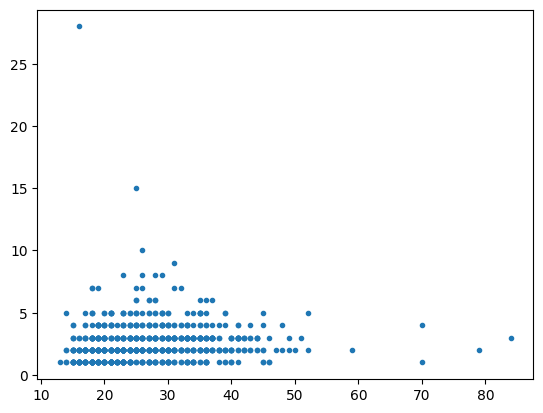

In [16]:
plt.plot(np.array(df['Age']),np.array(df['Number of sexual partners']),'.')

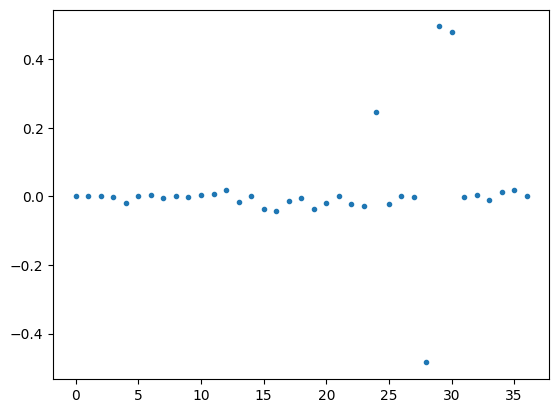

In [17]:
# trying linear regression to see which features contribute most
X = df.drop(['Dx:Cancer'],axis=1)
Y = df['Dx:Cancer']

reg = LinearRegression()
reg.fit(X,Y)
plt.plot(reg.coef_,'.')

In [18]:
cdf = pd.DataFrame(reg.coef_, X.columns, columns=['Coefficients'])
print(cdf)

                                    Coefficients
Age                                 1.645995e-05
Number of sexual partners          -1.872832e-04
First sexual intercourse            5.255656e-04
Num of pregnancies                 -1.193435e-03
Smokes                             -1.846863e-02
Smokes (years)                      4.120197e-04
Smokes (packs/year)                 5.200837e-03
Hormonal Contraceptives            -4.082141e-03
Hormonal Contraceptives (years)     1.379691e-03
IUD                                -8.917354e-04
IUD (years)                         2.494875e-03
STDs                                7.951483e-03
STDs (number)                       1.776352e-02
STDs:condylomatosis                -1.635344e-02
STDs:cervical condylomatosis        5.551115e-17
STDs:vaginal condylomatosis        -3.842618e-02
STDs:vulvo-perineal condylomatosis -4.292014e-02
STDs:syphilis                      -1.486864e-02
STDs:pelvic inflammatory disease   -6.031613e-03
STDs:genital herpes 

In [19]:
# seems that the biggest linear components are only because they're rare and so is the cervical cancer diagnosis...
print(df['STDs:HPV'].value_counts())
print(df['Dx:CIN'].value_counts())
print(df['Dx:HPV'].value_counts())
print(df['Dx'].value_counts())
print(df['Dx:Cancer'].value_counts())

0    856
1      2
Name: STDs:HPV, dtype: Int64
0    849
1      9
Name: Dx:CIN, dtype: Int64
0    840
1     18
Name: Dx:HPV, dtype: Int64
0    834
1     24
Name: Dx, dtype: Int64
0    840
1     18
Name: Dx:Cancer, dtype: Int64


In [20]:
y = Y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)
print(accuracy_score(y_test,y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
print(np.asarray((unique, counts)).T)
confusion_matrix(y_test,y_pred)
plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

0.9929577464788732
[[  0 280]
 [  1   4]]


NameError: name 'plot_confusion_matrix' is not defined

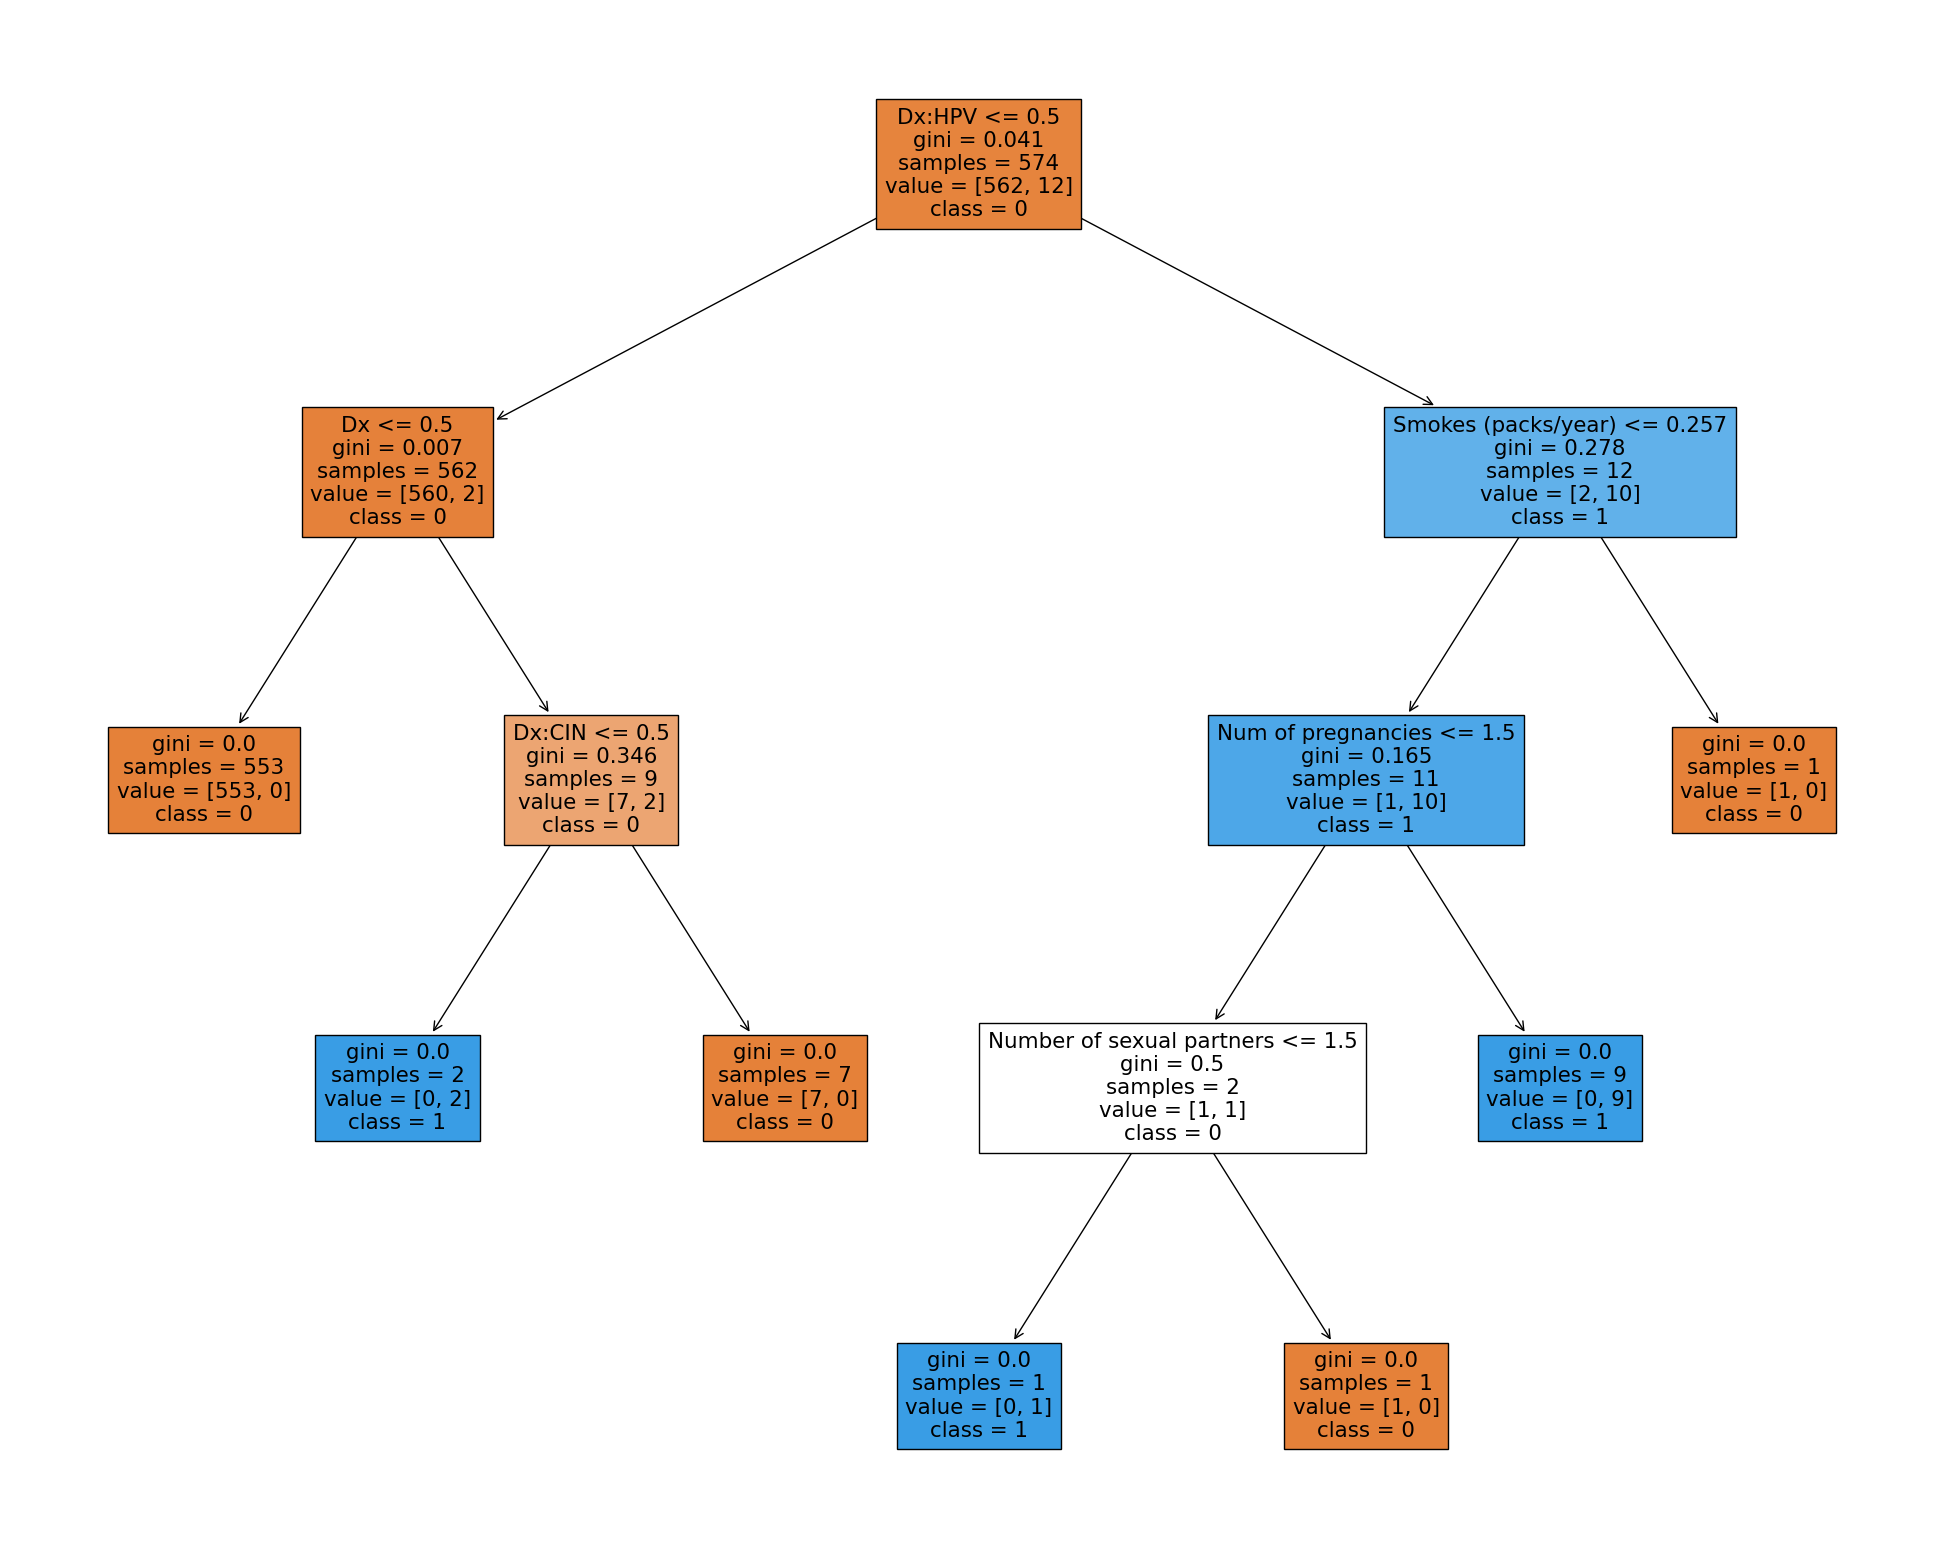

In [21]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(tree, 
                   feature_names=X.columns,  
                   class_names=['0','1'],
                   filled=True)

0.9894366197183099


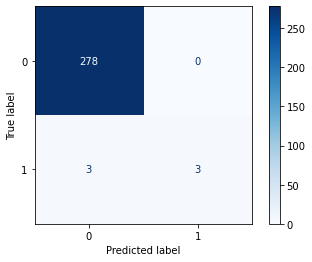

In [22]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
f_pred = forest.predict(X_test)
print(accuracy_score(y_test,f_pred))
confusion_matrix(y_test,f_pred)
plot_confusion_matrix(forest, X_test, y_test, cmap=plt.cm.Blues)
plt.show()